## Setup and Imports

In [1]:
! pip install -U -q transformers
! pip install -U -q accelerate
! pip install -U -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 987.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


In [2]:
import re
import numpy as np
from matplotlib import pyplot as plt

from transformers import (
    AutoProcessor,
    PaliGemmaForConditionalGeneration
)
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Configuration

In [3]:
dataset_id = "diffusers/tuxemon"
model_id = "google/paligemma-3b-pt-224"

device = "cuda:0"
dtype = torch.bfloat16

batch_size = 4
learning_rate = 5e-5

## Dataset for Fine Tuning

In [4]:
dataset = load_dataset(dataset_id, split="train")
dataset = dataset.train_test_split(test_size=0.3)

train_dataset = dataset["train"]
val_test_dataset = dataset["test"].train_test_split(test_size=0.2)

val_dataset = val_test_dataset["train"]
test_dataset = val_test_dataset["test"]

Generating train split:   0%|          | 0/251 [00:00<?, ? examples/s]

In [5]:
print(f"{len(train_dataset)=}")
print(f"{len(val_dataset)=}")
print(f"{len(test_dataset)=}")

len(train_dataset)=175
len(val_dataset)=60
len(test_dataset)=16


In [6]:
processor = AutoProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [10]:
def collate_train_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Caption the image." for _ in examples]
    suffix = [example["blip_caption"] for example in examples]

    # Help from: https://github.com/huggingface/transformers/issues/30987
    inputs = processor(
        images=images,
        text=prompt,
        suffix=suffix,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs

def collate_test_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Caption the image." for _ in examples]

    inputs = processor(
        images=images,
        text=prompt,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs

In [11]:
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=False,
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_test_fn,
    batch_size=batch_size,
    shuffle=False,
)

## Model creation

In [12]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

## Freezing everything but the attention layers

In [13]:
for name, param in model.named_parameters():
    if "attn" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [14]:
for name, param in model.named_parameters():
    print(f"{name:<70}: requires_grad={param.requires_grad}, dtype={param.dtype}")

vision_tower.vision_model.embeddings.patch_embedding.weight           : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.embeddings.patch_embedding.bias             : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.embeddings.position_embedding.weight        : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias      : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias      : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.bias      : requires_grad=True, d

## Dummy forward pass

In [15]:
val_batch = next(iter(val_dataloader))
test_batch = next(iter(test_dataloader))

In [18]:
print(f"{val_batch.keys()=}")
print(f"{test_batch.keys()=}")

val_batch.keys()=dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'labels'])
test_batch.keys()=dict_keys(['input_ids', 'attention_mask', 'pixel_values'])


In [17]:
outputs = model(**val_batch)
print(f"{outputs.loss=}")

outputs.loss=tensor(3.9624, device='cuda:0', grad_fn=<NllLossBackward0>)


## Results Before Fine Tuning

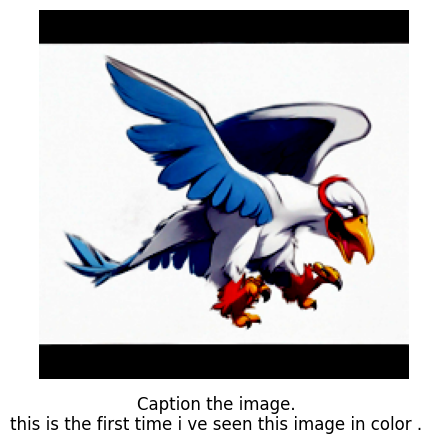

In [20]:
index = 0

plt.imshow(test_batch["pixel_values"][index].permute(1, 2, 0).cpu().to(torch.float32))
plt.axis("off")

generated_outputs = model.generate(
    **test_batch,
    max_new_tokens=30,
)
generated_outputs = processor.batch_decode(
    generated_outputs,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[index]

plt.figtext(
    0.5, 0.01,
    generated_outputs,
    wrap=True,
    horizontalalignment="center",
    fontsize=12
)

plt.show()

## Fine tune the model

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(10):
    for idx, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        if idx % 10 == 0:
            print(f"Epoch: {epoch} Iter: {idx} Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0 Iter: 0 Loss: 4.3709
Epoch: 0 Iter: 10 Loss: 0.9713
Epoch: 0 Iter: 20 Loss: 0.6482
Epoch: 0 Iter: 30 Loss: 0.8358
Epoch: 0 Iter: 40 Loss: 0.5750
Epoch: 1 Iter: 0 Loss: 0.5734
Epoch: 1 Iter: 10 Loss: 0.3605
Epoch: 1 Iter: 20 Loss: 0.5198
Epoch: 1 Iter: 30 Loss: 0.3686
Epoch: 1 Iter: 40 Loss: 0.2248
Epoch: 2 Iter: 0 Loss: 0.3729
Epoch: 2 Iter: 10 Loss: 0.1999
Epoch: 2 Iter: 20 Loss: 0.1623
Epoch: 2 Iter: 30 Loss: 0.1674
Epoch: 2 Iter: 40 Loss: 0.2823
Epoch: 3 Iter: 0 Loss: 0.3438
Epoch: 3 Iter: 10 Loss: 0.2409
Epoch: 3 Iter: 20 Loss: 0.2407
Epoch: 3 Iter: 30 Loss: 0.1861
Epoch: 3 Iter: 40 Loss: 0.2573
Epoch: 4 Iter: 0 Loss: 0.0724
Epoch: 4 Iter: 10 Loss: 0.0454
Epoch: 4 Iter: 20 Loss: 0.0873
Epoch: 4 Iter: 30 Loss: 0.0419
Epoch: 4 Iter: 40 Loss: 0.0260
Epoch: 5 Iter: 0 Loss: 0.0130
Epoch: 5 Iter: 10 Loss: 0.0166
Epoch: 5 Iter: 20 Loss: 0.0577
Epoch: 5 Iter: 30 Loss: 0.0405
Epoch: 5 Iter: 40 Loss: 0.0047
Epoch: 6 Iter: 0 Loss: 0.0432
Epoch: 6 Iter: 10 Loss: 0.0050
Epoch: 6 Iter: 

## Results After Fine Tuning

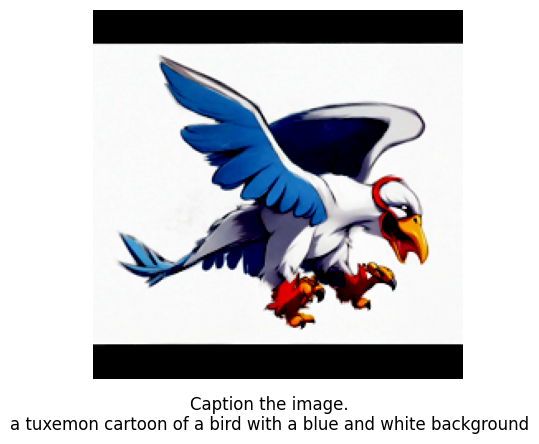

In [22]:
index = 0

plt.imshow(test_batch["pixel_values"][index].permute(1, 2, 0).cpu().to(torch.float32))
plt.axis("off")

generated_outputs = model.generate(
    **test_batch,
    max_new_tokens=30,
)
generated_outputs = processor.batch_decode(
    generated_outputs,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[index]

plt.figtext(
    0.5, 0.01,
    generated_outputs,
    wrap=True,
    horizontalalignment="center",
    fontsize=12
)

plt.show()